# **Import Library**

In [855]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# **Load Dataset**

In [856]:
df=pd.read_csv("/content/sample_data/House_Price_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# **Data Cleaning**

## Eliminate the irrelevant column to streamline the dataset

In [857]:
df = df.drop(['area_type', 'availability', 'society', 'balcony'], axis=1)
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Identify and handle null values in the data.

In [858]:
df.isnull().sum()

,0
location,1
size,16
total_sqft,0
bath,73
price,0


In [859]:
df = df.dropna()
df.isnull().sum()

,0
location,0
size,0
total_sqft,0
bath,0
price,0


## Extract the BHK number by splitting and selecting the first token

In [860]:
df['BHK'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df=df.drop(['size'],axis=1)
df.head()

/tmp/ipython-input-860-1052040218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BHK'] = df['size'].apply(lambda x: int(x.split(' ')[0]))


,location,total_sqft,bath,price,BHK
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


## Handle range values in total_sqft by averaging

In [861]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [862]:
def handle_range (x):
  temp = x.split('-')
  if len(temp) == 2:
    return (float(temp[0]) + float(temp[1]))/2
  try:
    return float(x)
  except:
    return None

In [863]:
df = df.copy()
df['total_sqft'] = df['total_sqft'].apply(handle_range)
df.head()

,location,total_sqft,bath,price,BHK
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


# **Feature Engineering**

## Derive Price Per Sqft from Total Price and Total Sqft Area

In [864]:
df= df.copy()
df['price_per_sqft'] = df['price']*100000 / df['total_sqft']
df.head()

,location,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


## Group rare locations under 'other' category

In [865]:
len(df.location.unique())

1304

In [866]:
df.location = df.location.apply(lambda x: x.strip())
location_stats = df.groupby('location')['location'].agg('count').sort_values(ascending=False)

In [867]:
location_less_than_10  = location_stats[location_stats <= 10]
len(location_less_than_10)

1052

In [868]:
len(df.location.unique())

1293

In [869]:
df.location = df.location.apply(lambda x: 'other' if x in location_less_than_10 else x)
len(df.location.unique())


242

# **Outlier handling for accurate modeling**

## Drop properties with insufficient area per BHK

In [870]:
df[df.total_sqft/df.BHK < 300].head()

,location,total_sqft,bath,price,BHK,price_per_sqft
9,other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
70,other,500.0,3.0,100.0,3,20000.000000


In [871]:
df.shape

(13246, 6)

In [872]:
df = df[~ (df.total_sqft/df.BHK < 300) ]
df.shape

(12502, 6)

## Removing Outliers Based Price per sqft using Mean and Standard Deviation

In [873]:
df.price_per_sqft.describe()

,price_per_sqft
count,12456.000000
mean,6308.502826
std,4168.127339
min,267.829813
25%,4210.526316
50%,5294.117647
75%,6916.666667
max,176470.588235


In [874]:
def remove_pps_outliers(df):
  df_out = pd.DataFrame()
  for key, subdf in df.groupby('location'):
    m = np.mean(subdf.price_per_sqft)
    st = np.std(subdf.price_per_sqft)
    reduced_df = subdf[(subdf.price_per_sqft > (m-st)) & (subdf.price_per_sqft <= (m+st))]
    df_out = pd.concat([df_out, reduced_df], ignore_index=True)
  return df_out
df = remove_pps_outliers(df)
df.shape

(10241, 6)

In [875]:
df.price_per_sqft.describe()

,price_per_sqft
count,10241.000000
mean,5657.702572
std,2266.476980
min,1250.000000
25%,4244.762955
50%,5172.413793
75%,6426.099852
max,24509.803922


## Removing Outliers Based BHK

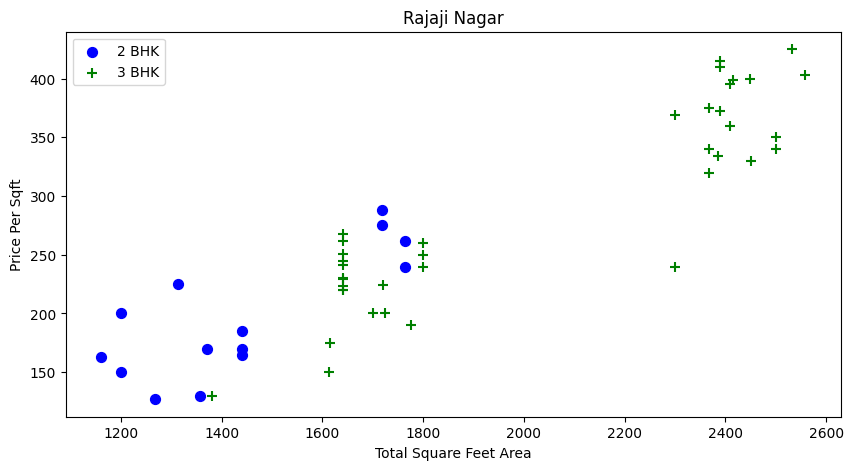

In [876]:
def scatter_plot(df, location):
  bhk2 = df[(df.location == location) & (df.BHK == 2)]
  bhk3 = df[(df.location == location) & (df.BHK == 3)]
  matplotlib.rcParams['figure.figsize'] = (10,5)
  plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
  plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
  plt.xlabel('Total Square Feet Area')
  plt.ylabel('Price Per Sqft')
  plt.title(location)
  plt.legend()

scatter_plot(df, 'Rajaji Nagar')




In [877]:
def remove_BHK_outliers (df):
  exclude_indices = np.array([])
  for location, location_df in df.groupby('location'):
    BHK_stats = {}
    for BHK, BHK_df in location_df.groupby('BHK'):
      BHK_stats[BHK] = {
          'mean': np.mean(BHK_df.price_per_sqft),
          'std': np.std(BHK_df.price_per_sqft),
          'count': BHK_df.shape[0]
      }
    for BHK, BHK_df in location_df.groupby('BHK'):
      stats = BHK_stats.get(BHK-1)
      if stats and stats['count'] > 5:
        exclude_indices = np.append(exclude_indices, BHK_df[BHK_df.price_per_sqft < (stats['mean'])].index.values)
  return df.drop(exclude_indices, axis='index')
df = remove_BHK_outliers(df)
df.shape

(7329, 6)

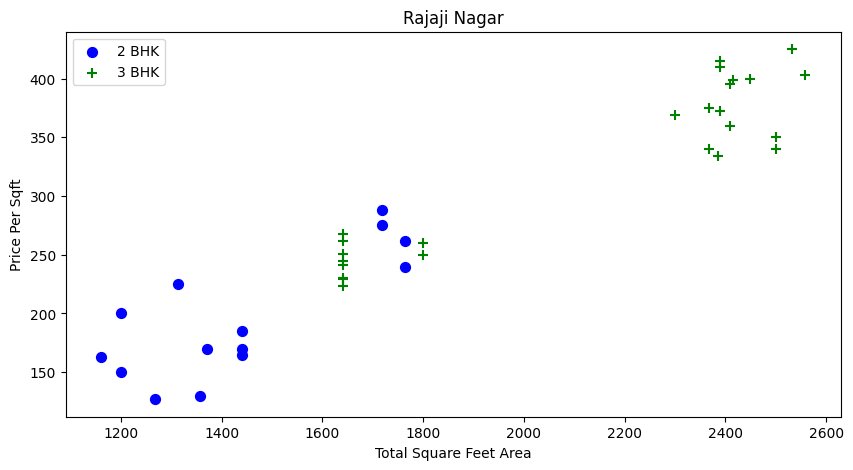

In [878]:
scatter_plot(df, 'Rajaji Nagar')

Text(0, 0.5, 'Count')

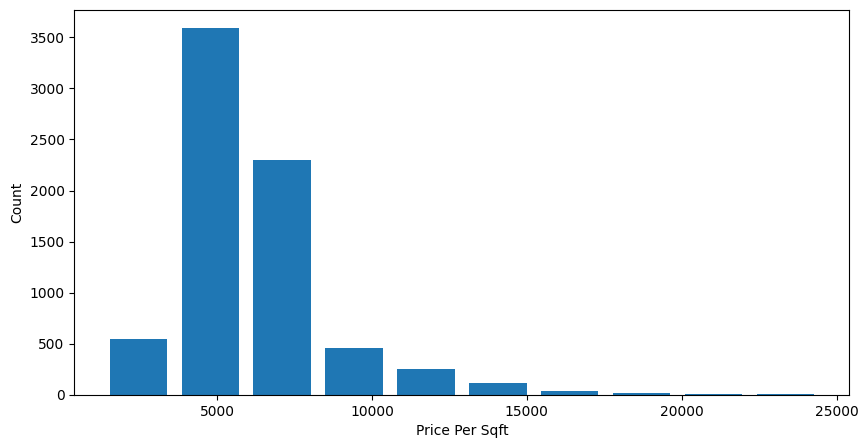

In [879]:
matplotlib.rcParams['figure.figsize'] = (10,5)
plt.hist(df.price_per_sqft, rwidth=0.8)
plt.xlabel('Price Per Sqft')
plt.ylabel('Count')

## Removing Outliers Based on Number of Bathrooms

In [880]:
df.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [881]:
df[df.bath > 10]

,location,total_sqft,bath,price,BHK,price_per_sqft
5277,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
8486,other,12000.0,12.0,525.0,10,4375.000000
8575,other,10000.0,16.0,550.0,16,5500.000000
9308,other,6000.0,12.0,150.0,11,2500.000000
9639,other,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

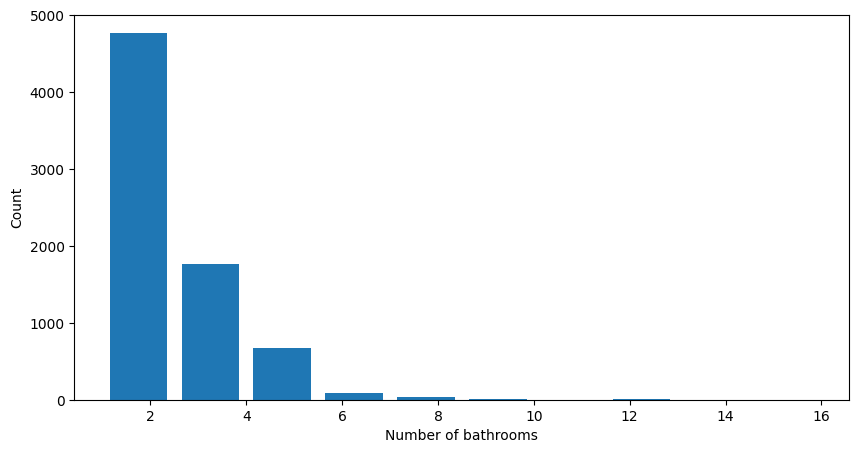

In [882]:
plt.hist(df.bath, rwidth=0.8)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')

In [883]:
df[df.bath > df.BHK+2]

,location,total_sqft,bath,price,BHK,price_per_sqft
1626,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,1806.0,6.0,116.0,3,6423.034330
8411,other,11338.0,9.0,1000.0,6,8819.897689


In [884]:
df = df[df.bath < df.BHK+2]
df.shape

(7251, 6)

In [885]:
df = df.drop(['price_per_sqft'], axis=1)
df.head()

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


# **Machine Learnig Model Building**

## One-Hot Encoding (OHE)

In [886]:
dummies = pd.get_dummies(df.location)
dummies.head(5)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [887]:
df = pd.concat([df,dummies.drop(['other'], axis=1)], axis=1)
df.head()

,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [888]:
df = df.drop(['location'], axis=1)
df.head()

,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,235.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,130.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,148.0,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [889]:
df.shape

(7251, 245)

## Data Separation as X (Independent Variable) and Y (Dependent Variable)


In [890]:
x = df.drop("price", axis=1)
x.head()

,total_sqft,bath,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [891]:
y = df["price"]
y.head()


,price
0,428.0
1,194.0
2,235.0
3,130.0
4,148.0


## Data Spliting

In [892]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

## Liner Regression Train the Model with X_train and Y_train

In [893]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.8452277697874329

## Cross-Validation Method

In [894]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), x, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

## Grid Search Cross-Validation

In [895]:
def find_best_model_using_gridsearchcv(x, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


find_best_model_using_gridsearchcv(x, y)

,model,best_score,best_params
0,linear_regression,0.819001,{'fit_intercept': False}
1,lasso,0.687429,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.714400,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


## Predict the Price

In [896]:
def predict_price(location, sqft, bath, BHK):
  loc_index = np.where(x.columns == location)[0][0]
  x_input = np.zeros(len(x.columns))
  x_input[0] = sqft
  x_input[1] = bath
  x_input[2] = BHK
  if loc_index >= 0:
    x_input[loc_index] = 1

  return lr.predict([x_input])[0]


In [897]:
predict_price('Indira Nagar', 1000, 3, 3)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(184.5843020203339)

# **Export Machine Model**

In [898]:
import pickle
with open('House_Price_Model.pickle', 'wb') as f:
  pickle.dump(lr, f)